<a href="https://colab.research.google.com/github/andrebelem/ensino/blob/main/Ploting_ERA5_data_with_Proplot_using_COLAB_%5BPUBLIC%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](http://observatoriooceanografico.org/wp-content/uploads/elementor/thumbs/logo-o2-2-p31vla9ib17i85olifd4l1xk0e5lktrkal6u0s4c6o.png)<br>
# How to read ERA5 data via API and plot with Proplot
### An example for Earth Sciences and Climate Change students
#### Preferential plataforms: Jupyter Notebook/Jupyter Lab/COLAB.
<br>

Created by [A.L. Belém](mailto:andrebelem@id.uff.br) @ [Oceanographic Observatory](http://www.observatoiriooceanografico.uff.br) 2021 (version 1) for colaborators in the O2 (and for those who are most interested)<br>

History:<br>
[April 12th, 2021 Version 1] Main example<br>
[May 28th, 2021] Adapted to COLAB (ProPlot)<br>
[Oct 22th, 2021] A few modifications to use ORA5 (ProPlot)



**NOTA: If you modify this notebook, be careful not to distribute your sensitive data to access the CDS. Check before distributing**

This notebook was *stimulated* by participating in the **Introduction to Scientific Python** course given by the meteorologist [Willy Hagi](https://linktr.ee/willyhagi) from [Meteonorte](https://www.meteonorte.com/) between April 10 and 11, 2021, and based on *lessons learned* from the [Luke Gloege](https://lukegloege.medium.com/) in [Towards data science](https://towardsdatascience.com/read-era5-directly-into-memory-with-python-511a2740bba0) about the [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview) data.

The idea here is to mix the ERA5 and the [Proplot](https://proplot.readthedocs.io/en/latest/) (and [Cartopy](https://scitools.org.uk/cartopy/docs/v0.13/index.html)). `CartoPy` is a package created by **UK Met Office** with the aim of allowing cartographic projections and plotting various types of geospatial data in Python. `Proplot` is an excellent library that facilitates the plotting of maps based on `CartoPy`, much more *clean* and *direct* than with the native package. **Note for COLAB**: There are a number of difficulties to run `ProPlot` on COLAB, but with a little patience, you can configure your virtual machine to (re)install the necessary packages. See below throughout the text.

ERA5 is a fifth generation climate reanalysis produced by the European Center for Medium-Term Meteorological Forecasts (ECMWF) and it provides a time output for many atmospheric, land surface and ocean parameters, along with some uncertainty estimates. The volume of data is immense, as well as its potential, which makes routine work with local data almost impossible if you try to download the whole thing. Working in the cloud is the way out to not take up space and consume internet bandwidth (which is quite inconsistent for those concerned with the climate x energy). This notebook was created as a "cake recipe" for the installation of the climatic data storage API (CDS), which will allow the reading and analysis of ERA5 data inside Python.

### The basics of ERA5 and the CDS API

Access via CDS API allows work on data sets from ERA5 and ERA5-land (the same dataset but only on land). There are four main subsets of ERA5: hourly and monthly products, each at pressure levels (including air fields at altitude) and simple levels or single levels (atmospheric, oceanic and terrestrial surface quantities). ERA5-land only includes single levels. If you are in a hurry, then ...
The four ERA5 subsets are (take a tour at [Copernicus data hub](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset)):
- ERA5 hourly data at single levels
- Average monthly data ERA5 at individual levels
- Hourly data ERA5 on pressure levels
- Average monthly data ERA5 on pressure levels

The two ERA5-land subsets:
- ERA5-land hourly data
- ERA5-land monthly data

The ERA5 reanalysis is described in detail in the paper Hersbach, H, Bell, B, Berrisford, P, et al. The ERA5 global reanalysis. Q J R Meteorol Soc. 2020; 146: 1999– 2049. https://doi.org/10.1002/qj.3803. Please, give them the credit. 

#### First, reconfiguring your machine<br>

**These steps below are exclusively for COLAB**<br>

To get you all the packages you need, let's (1) update the machine packages and install what you need, (2) resolve the dispute between `shapely` and `cartopy`, and (3) install `proplot` . <br>
**Attention:** this operation can take 2 to 3 minutes. Get a coffee and have a little patience.

In [1]:
%%capture
# ** exclusive to COLAB
# That was the ultimate "cake recipe" which worked after all. Note that it updates machine packages first
!grep '^deb ' /etc/apt/sources.list | \
  sed 's/^deb /deb-src /g' | \
  tee /etc/apt/sources.list.d/deb-src.list
!apt-get update

# then install cartopy and remove shapely (which doesn't talk to cartopy in collab)
!apt-get -qq build-dep python3-cartopy
!apt-get -qq remove python-shapely python3-shapely
# and finally reinstall shapely and cartopy in the required version
!pip install --no-binary shapely shapely --force

!pip install --no-binary cartopy cartopy==0.17.0
# finally, install the proplot
!pip install proplot

#### Second, access to the CDS API

Nothing will happen if you don't install the CDS API key and for that you need to create a Copernicus account and store your unique API key in a dot file. Here are the steps to do this:
1. Create an account on Copernicus [here](https://cds.climate.copernicus.eu/)
2. Once created, log into your Copernicus account ([here](https://cds.climate.copernicus.eu/user)), and note the `UID` and `API key` that appears at the end of the page if you just created OR click on your username on the main page and note that at the bottom of the page will be this information. I suggest you copy-paste it to a notepad or similar.
3. Modify the *code snippet* below using a text editor, modifying the `<UID>` and `<API key>` values with the ones you saved.

'url: https://cds.climate.copernicus.eu/api/v2'<br>
'key: \<UID\>:\<API key\>'<br>
'verify: 0'<br>

**Note** that the filename must be `.cdsapirc` and it must be created in your `$HOME` (regardless of whether it is in windows or linux). **(Special note for COLAB!)**: The code below is for you to ensure that your key data will be in the virtual machine home. However, **careful** if you are going to share this notebook on the network as it contains your personal CDS access key.

You can create directly in linux terminal or via notepad in Windows. As a integrity check (and your sanity), check the contents of the `.cdsapirc` file to make sure everything looks correct. A correct file will look like this one: recorded.

'url: https://cds.climate.copernicus.eu/api/v2'<br>
'key: 54321:a77a7a7a-7a77-7777-7777-aa77a7a77a7a'<br>
'verify: 0'<br>

(**Obviously** don't copy the contents of the above file as yours because it won't work).
<br>

In [2]:
# If you use Jupyter, create the .crsapirc file "outside" and skip this step
# COLAB EXCLUSIVE .... creation of the key in the COLAB home page
###### change the data to your own key ######
!echo url: https://cds.climate.copernicus.eu/api/v2 > ~/.cdsapirc
!echo key: 00000:a111111z-11z1-11z0-abc1-1111a0aaaaz1 >> ~/.cdsapirc
!echo verify:0 >> ~/.cdsapirc
# and check if everything is ok
!more ~/.cdsapirc

url: https://cds.climate.copernicus.eu/api/v2
key: 00000:a111111z-11z1-11z0-abc1-1111a0aaaaz1
verify:0


#### Third, install the CDS API client

Something that hasn't been mentioned before but is quite salutary is that you use a *virtual environment* ((see here)[https://docs.conda.io/projects/conda/en/latest/user-guide/concepts/environments .html]). Regardless, installing the `cdsapi` client is done via `conda` or `pip`:

`pip install cdsapi` (Mainly in COLAB)
or
`conda install cdsapi`

Once installed, make sure you can import and start the client in a Python script without errors, for example by creating a small program or running the line below.
<br>

In [4]:
# COLAB Exclusive
# Install CDS api for access now.
%%capture
!pip install cdsapi

In [5]:
# and finally, import your client to download ERA5
# Run this command in any environment, regardless of whether it's COLAB or Jupyter
# if everything worked out, you can already work with the CDS api.
import cdsapi
cds = cdsapi.Client()

#### Now it's easy! using the CDS API client

The code below shows how to request monthly average temperatures at a specified pressure level over a range of dates. The output is stored in memory as a `xarray` dataset and can be turned on or off using the `download_flag`.

**Note** that not all Copernicus datasets have the option to download directly to netcdf. But there is a way around this.

In [6]:
import warnings ## better turn this on if you don't want to fill your screen with messages
warnings.filterwarnings("ignore")

In [7]:
import cdsapi
import xarray as xr
from urllib.request import urlopen
# start the client
cds = cdsapi.Client()
# dataset you want to read
dataset = "reanalysis-era5-pressure-levels-monthly-means"
# flag to download data
download_flag = False
# api parameters 
params = {
    "format": "netcdf",
    "product_type": "monthly_averaged_reanalysis",
    "variable": "temperature",
    "pressure_level": '1000',
    'year':['2019','2020'],
    'month':['01','02','03'],
    "time": "00:00", 
    "grid": [1.0, 1.0],
    "area": [90, -180, -90, 180],
    }
# retrieves the path to the file
fl = cds.retrieve(dataset, params)
# download the file 
if download_flag:
    fl.download("./output.nc") ## note you are poiting directly to the output.nc file
# load into memory
with urlopen(fl.location) as f:
    dset = xr.open_dataset(f.read())

2021-10-22 17:56:57,694 INFO Welcome to the CDS
2021-10-22 17:56:57,696 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels-monthly-means
2021-10-22 17:56:57,891 INFO Request is completed


In [8]:
dset # for you to take a look at what you've downloaded

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, time: 6)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2020-03-01
Data variables:
    t          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-21 23:29:39 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [9]:
# note that you can experiment. Some fields have 4 dimensions and others 3. Adapt below depending on your need;
#air = dset['t'][-1,1,:,:] -273.15
air = dset['t'][-1,:,:]-273.15

And now we can use simple code with Proplot to plot projections with the global Air Temperature (t) fields, also employing Matplotlib's .contourf() function. Note that the temperature is in Kelvin. Another relevant point is that an `expver` dimension (**1** or **5**) may appear here, which are the versions of ERA5 (`expver 1`) and ERA5-Land (`expver 5`) (see explanation (here)[https://confluence.ecmwf.int/pages/viewpage.action?pageId=173385064]). If necessary you will need to make a pre-selection before plotting. Modify if necessary.

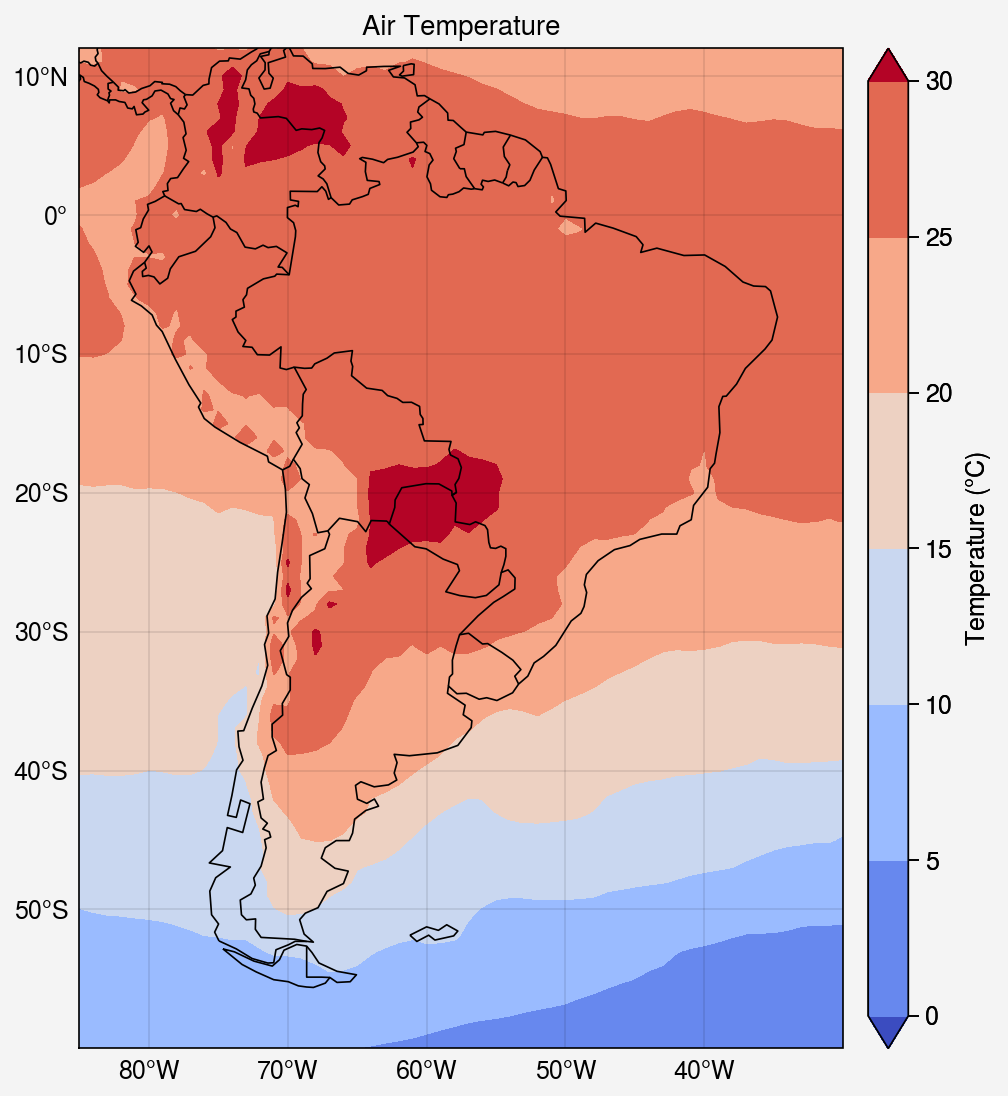

In [10]:
import proplot as plot
fig, ax = plot.subplots(axheight=5, tight=True,
                         proj='pcarree',)

ax.format(coast=True, borders=True, innerborders=False,
          labels=True, latlines=10, lonlines=10,
          latlim=(12, -60), lonlim=(275, 330),
          title='Air Temperature')

map1 = ax.contourf(dset['longitude'], dset['latitude'],
                   air,
                   cmap='coolwarm', levels=plot.arange(0, 30, 5),
                   extend='both')

fig.colorbar(map1, loc='r', label='Temperature ($\degree$C)')
plot.show()

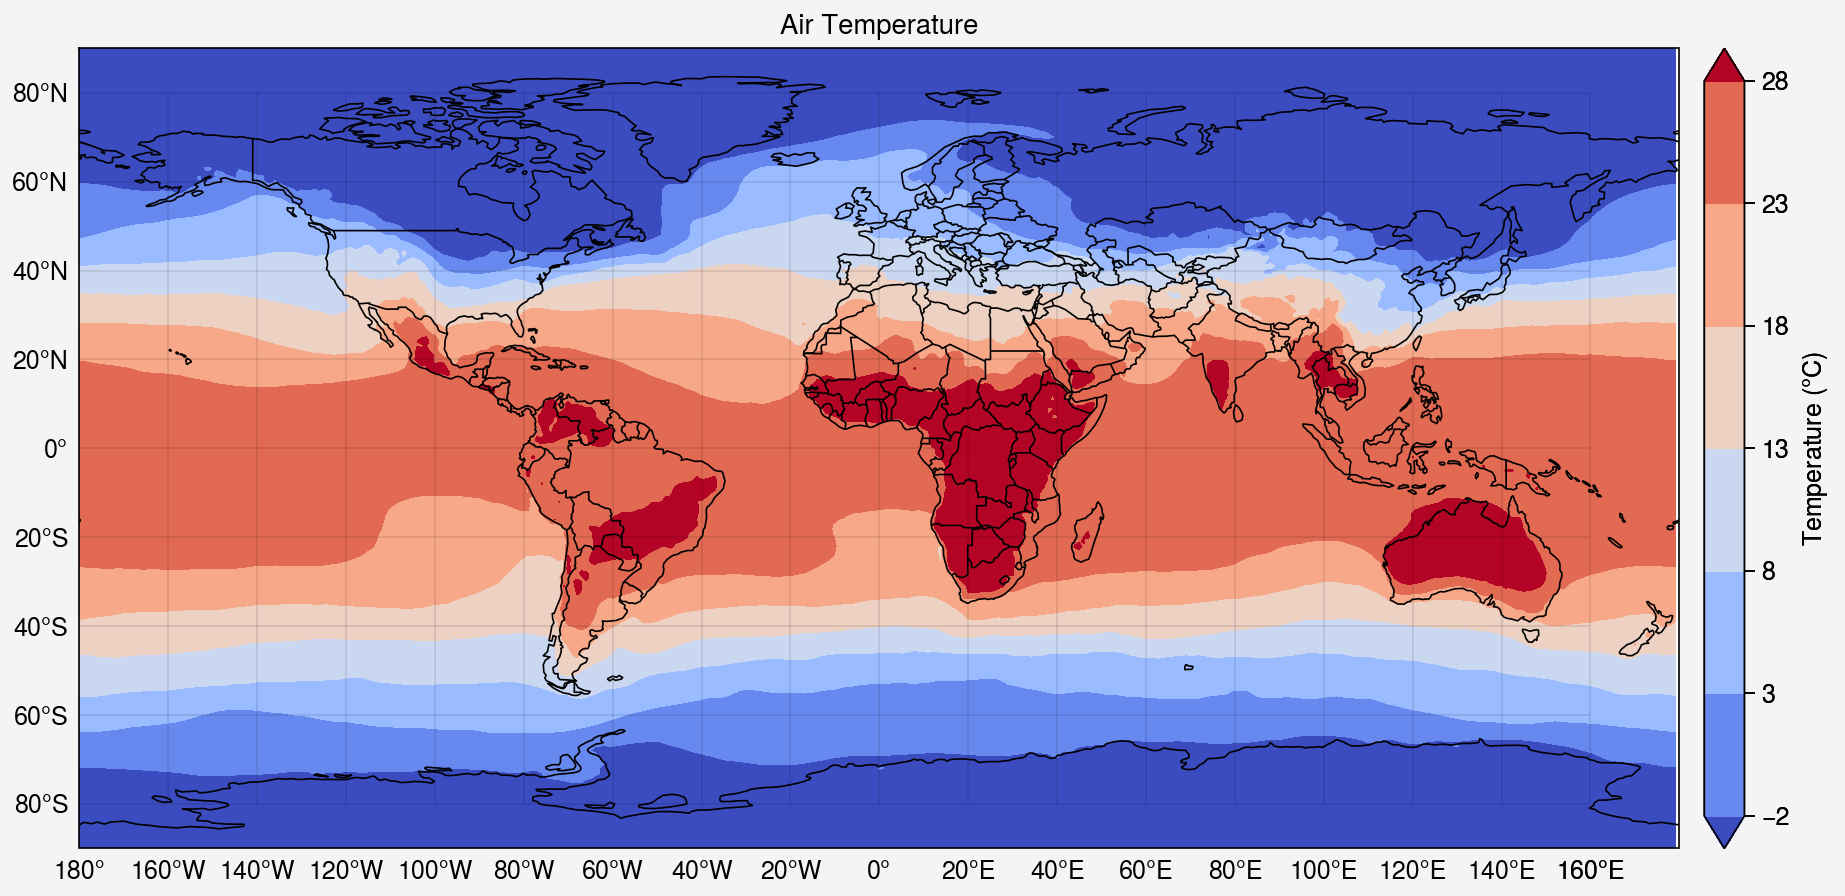

In [11]:
# How about the whole globe? and with the average time of the dset we downloaded ?

import proplot as plot
fig, ax = plot.subplots(axheight=4, tight=True,
                         proj='pcarree',)

ax.format(coast=True, borders=True, innerborders=False,
          labels=True, latlines=20, lonlines=20,
          latlim=(-90, 90), lonlim=(-180, 180),
          title='Air Temperature')

map1 = ax.contourf(dset['longitude'], dset['latitude'],
                   dset.t.mean(dim='time')-273.15, # note here I'm doing the average over time
                   cmap='coolwarm', levels=plot.arange(-2, 30, 5),
                   extend='both')

fig.colorbar(map1, loc='r', label='Temperature ($\degree$C)')
plot.show()

In place of the year, month, day and time parameters, you can alternatively specify a list of dates:

`'date':['2020-01-01 12:00', '2020-02-01 12:00', '2020-03-01 12:00'],`

or you can specify a date and time like this:

`'date':['2020-01-01', '2020-02-01', '2020-03-01'],`
`'time: '12:00', `

Whether you use one or the other, the result is the same when requesting the API. These requests are very specific and most of the time you can request a continuous interval, such as `'date':'2020-01-01 12:00/2020-03-01 12:00'`.

You can still use pandas as a `date_range`, but note that the input to the API must be a list of *strings*. Here is an example of using pandas:

`'date': list(pd.date_range('2020–01–01 12:00','2020–03–01 12:00', freq='M').strftime('%Y-%m-% d %H:%M')),` (**beware of quotes**).
<br>
<br>
#### More useful tips

**Error messages** <br>
If no data is available in the requested subset and the request returned no data, an error message will appear.<br>
`no data is available within your requested subset. Request returned in the data`
This usually indicates that a keyword value is out of the available range. For example, only a specific set of pressure levels can be ordered. Also, the time parameter must be to the nearest hour using a 24-hour clock. Below are the common errors I see and how to fix them:

- The pressure level must be contained in: `[1, 2, 3, 5, 7, 10, 20, 30, 50, 70, range(100, 1000, 25)]`, where the range (100,1000 ,25) indicates 100 to 1000 in increments of 25. If you get an error, check that the pressure you are requesting is contained in this list.
- The time must correspond to the nearest hour on a 24-hour clock: `00:00, 01:00,…, 23:00`. If you get an error, check if the time is the closest time. If you are requesting monthly averages, make sure the time parameter is set to `‘00:00’`.

There is a huge [forum](https://confluence.ecmwf.int/display/CUSF/forum) for the CDS API and you can ask your questions there. There is no extensive CDS API documentation but a lot of information can be obtained [here](https://cds.climate.copernicus.eu/api-how-to). Some allowed keywords and variable names vary depending on the dataset. The following links are helpful:
- The allowed keyword parameters for each dataset are [this link](https://confluence.ecmwf.int/display/CKB/Climate+Data+Store+%28CDS%29+API+Keywords).
- Available variables are listed in [tables like this one](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation). You provide what is listed in the variable name in the CDS column.
- You can also refer to the example script [here](https://confluence.ecmwf.int/display/CKB/Climate+Data+Store+(CDS)+API+Keywords).

Another option is to use the web interface to make a selection and see “show API request” at the bottom. For example, use [this link](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels-monthly-means?tab=form) to choose the "**average monthly pressure levels**". Other datasets can be found [here](https://cds.climate.copernicus.eu/#!/search?text=ERA5&type=dataset). Click on the dataset you want to access and then on the “Download data” (or `download data`) tab to make your selection. *The sky (or ocean) is the limit*.


#### Jupyterize your scripts by making the API easier to use

Once you understand how it works, you realize that the CDS API is extremely very powerful. Share with your colleagues, "pythonize yourself". All information here is open source. Feel free to copy it and modify it as you wish. If you use COLAB, even better because then anyone can use it, anywhere.

<img src='https://www.python.org/static/community_logos/python-logo-master-v3-TM-flattened.png' width=150px></img>
<img src='https://cdn.iconscout.com/icon/free/png-256/love-chat-2125802-1789050.png' width=50px></img>
<img src='https://miro.medium.com/max/1400/1*7oukapIBInsovpHkQB3QZg.jpeg' width=150px></img>

